In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
from scipy.optimize import fsolve
from scipy.integrate import odeint, quad
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.optimize import minimize_scalar as sc
import os
from spectrum_class import Spectrum
from molarity_class import Molarity
from diagnostic_class import Diagnostic
import spectrochempy as ch
import re

"<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABgAAAAYCAYAAADgdz34AAAAAXNSR0IArs4c6QAAAAlw SFlzAAAJOgAACToB8GSSSgAAAetpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6 bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDUuNC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8x OTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAg eG1sbnM6eG1wPSJodHRwOi8vbnMuYWRvYmUuY29tL3hhcC8xLjAvIgogICAgICAgICAgICB4bWxuczp0aWZmPSJodHRwOi8vbnMu YWRvYmUuY29tL3RpZmYvMS4wLyI+CiAgICAgICAgIDx4bXA6Q3JlYXRvclRvb2w+bWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4wLCBo dHRwOi8vbWF0cGxvdGxpYi5vcmcvPC94bXA6Q3JlYXRvclRvb2w+CiAgICAgICAgIDx0aWZmOk9yaWVudGF0aW9uPjE8L3RpZmY6 T3JpZW50YXRpb24+CiAgICAgIDwvcmRmOkRlc2NyaXB0aW9uPgogICA8L3JkZjpSREY+CjwveDp4bXBtZXRhPgqNQaNYAAAGiUlE QVRIDY1We4xU1Rn/3XPuYx47u8w+hnU38hTcuoUEt/6D2y4RB0ME1BoEd9taJaKh9CFiN7YGp7appUAMNmktMZFoJTYVLVQ0smsy 26CN0SU1QgsuFAaW3WVmx33N677O6XfuyoIxTXqSO/fec+75fd93vt/3/UbDV0aKSZmCpkFMLz3T9utuu2N+o98aDSMBKVAo89z5 y+zEz3ZafcCOfvWdlGCalqKn1Bf71CygTd+mf1esSOnpdMpTb+vWpTZuWVfe3jLPa5tzHYNm0T5N0gpdkkHaDBeGBU6d1/t/fyS8 +/CbqdfUvmsx1PuMgc2bNxv79u1zgd31r+7JH1jbIZKxWRXAcYUQ8IWvBfBXNjEuJWPgMA02NR7C3/pYT9fjdZ3A9tGrWF8YSJHn qcDz3y7q2T967PZv+gnYJdd1mEZ+62zGDQV/dQgKhmLzDNOXCEWM3j6eTT5Y3w78dOBKJLR1PQf+4ivPj76UPZnssBN+wbM9Aet/ AV81Mf1EEULXYfOobvX2WWQk0aoioXwwSmirOlioY0mu8BIouzYl7P8GV3vpqCCEZvlFz769w08oLDWvyKIyL1asSm28d6WfzA97 ztvvV1kexUMsmhlkULEkuGYmFYC6AvfUrITnwUKl5K79lkjeSSRRTCTbQPd95e1WzMbZSya74XoXAxctCllCnbECMOjZNGRwvzIX nD85wbkMmKK+U045Dtdi8Qp+SAxU2GTg2bYlC9224pgvmSb54vkVTBQYyhUt2KjAMyMmPjwRQW5Mh2WKwJhlBh6jVGagFM84wZnQ 4bpC0Rt4pk1PbSt0NDcxDA5xryosDHWgtbM0DGZDWLSoiDMDYeQnGVrmOThxLozB0RAaahzkJzjKNqcIQBymJFMkOlN8Dqjpg0XY Tx5xO/QbmmUrqIjGJznq47TqTaClKYfjp+PInLMwnOdYvtQBZ2XcunQY+VwIo4U4muoFEjVEFE6lQyEUKzHYfgQG9ylCyngU+Cxj tOqxCDGHcCsOMCs6iQul5ZiStdATYxjMZXDLTUVwLY8Jey4uOh2IxjwsrP8UXJYxUrkZrghBahzV5iXU6gNkq0Z1EzIsUBUSCV2n EOHo0LVxHCpuxabJJdhi5PFnvw5vLXwXIfNZvD/+JNo/X40NegE54sUaazl+UL8XD1x+FB9Ijjt4EQfdGN6J/x131LwIV9ap/AYs 0x1fz1ZKFbh6A7qKy/By9Dg6G36Ep91vUJJ15Cqr0Z67E8/HzmBrw1OwxWyM+3Mo6BAuSB17oyfx0Oyl2DN0Hqs/70Cx6hBCvESF UY1ShWXZZEE7OTAYxZzaPH4TuoiusZvRnunFy2NbiHYuBp2vB66srX4vMEjpRKPxKXmnoQ4+Mn4DPiv8CYcrs3GfNUXJLtM+alSO hrMj/KT+wBNW3+E/2liywNO3iSflbaFva/+stGDTxE0E9Sjaox8HBhxpEamzMGSEaFKg+mjEddzDh1MxTDq3YV1kGBsjfwW3S9Cq anjmko+ndlb1UR3s6K8JlfphNWq9Ew/7c61T2BB/EbcaNkb8GBaE0tANH7/M34PLdhJDzjIcL9xPbdTG6zyM72Y+wXPHmvB489No fm0b5HnbQ9Rgp/7DSSd29AeVvPeNyK6JcYl/yQVi5dBjuGvoV/gaJe47s45QUxrDmcYX0MBsdF7egvXZ7+O0vZA4X8QmOQWjlSK7 RDz5wIM30gp9UbWcGjXxhzdDu1SiNSpx6kcQB57rPnr/3dlkZarWLnlRq5oPET1dOCIOk4wALib9eeS5iygfhkd09H0DWphB/+gs +PcOAS+ssrFmmXXgVfR0de9cpbAJfH3Q1jofW9DZk56dDcVsq9YcsoUMEd1qyLoT3BX1YiyHMJuk97hyjqIoE91t+NcTLeN0ZrfM oXatZbu6G0h4VG+ibqq0IJVK6cAjo6serG3vSUezCMct0yQeSOFJSUImqb2qbknUpDqlZxE0QZ+ZUpSlZx79h4Nda6zef9dlk121 JDjbR5XggPRZlRnS6bRQRtLpn4++cuie/Yvn2svmNxuLw9WCcYIl4fEoTEGiSTUqJdfgU+8ROqf1iMkLzS389YtNPXc/PH8l8ONB JZkHD+4JtD04HmVEDWWErmBhzV2/2LB1bemJG6krzv2S6NOHUgtEP0Oif5pE/3fHoruP7N8RiP61GArzSwbUhJJQpXJKiKbfr/3b IhKq76sKPUdF9NW/LSqfSn6vjv8C45H/6FSgvZQAAAAASUVORK5CYII=' style='height:25px; border-radius:12px; display:inline-block; float:left; vertical-align:middle'>",SpectroChemPy's API - v.0.6.8© Copyright 2014-2024 - A.Travert & C.Fernandez @ LCS


In [2]:
# ----- Obtain the path to the spa folder
path = os.path.dirname(os.getcwd())

path_spa = path + '\\spa data\\'

In [ ]:
# Initialize an empty dictionary to store data
data_dict = {}
keys = np.array([0,.4,.7,1,1.3,1.6])

i = 0
# Loop through each inner folder
for molarity_folder in os.listdir(path_spa):
    # Construct the full path to the inner folder
    molarity_folder = os.path.join(path_spa, molarity_folder)
    
    # Check if the path is a directory
    if os.path.isdir(molarity_folder):
        # Initialize an empty list to store data from files in this inner folder
        data = ch.read_omnic(molarity_folder)
        
        data_dict[keys[i]] = data
        i += 1

print(data_dict.keys())

dict_keys([0.0, 0.4, 0.7, 1.0, 1.3, 1.6])


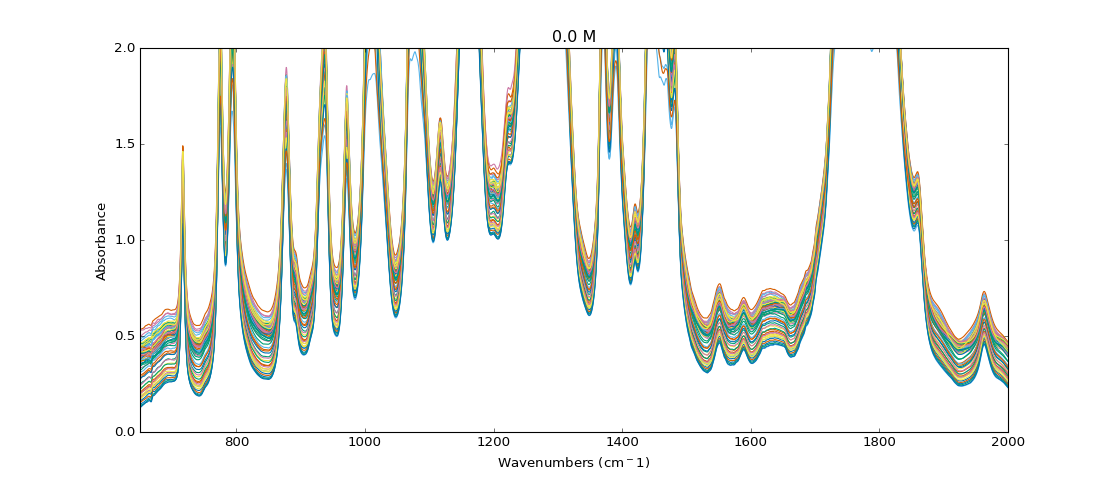

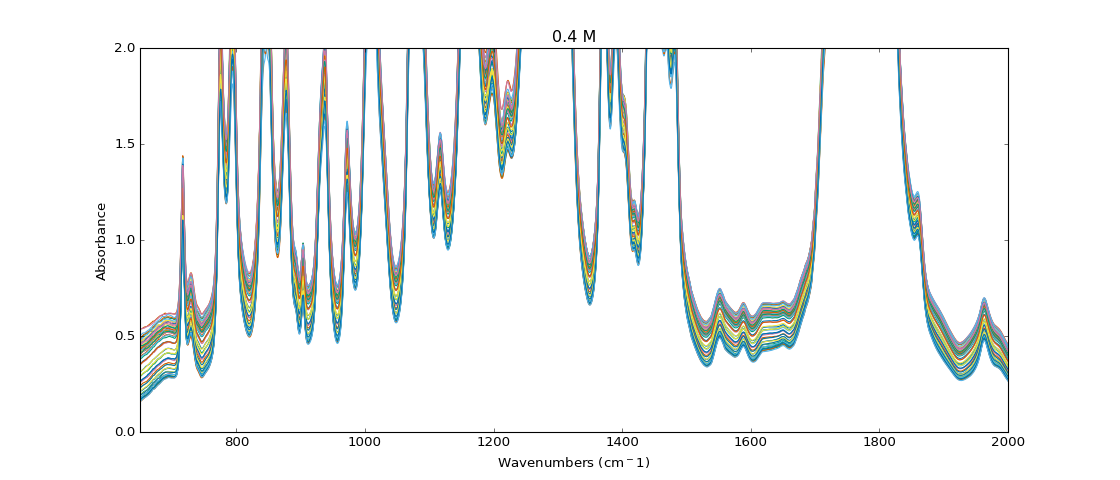

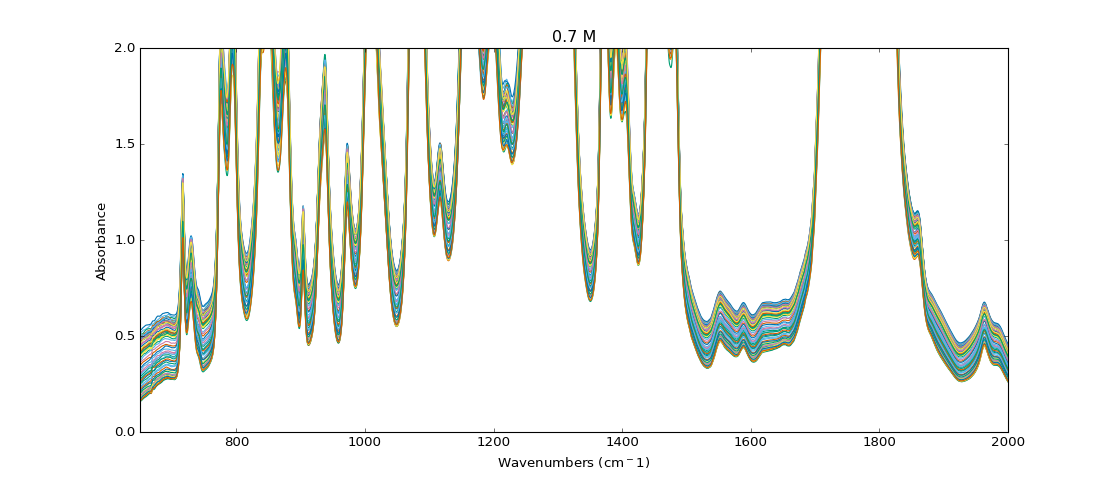

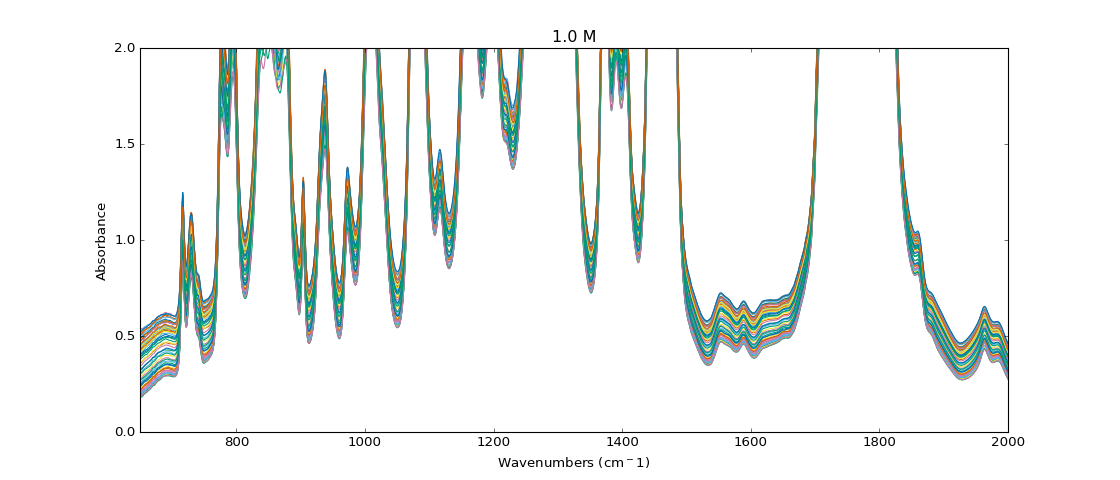

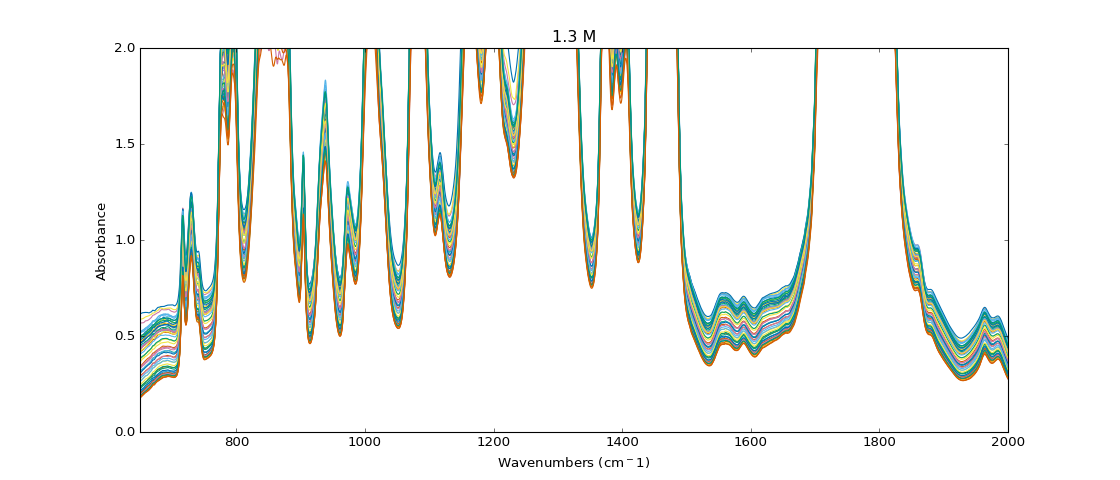

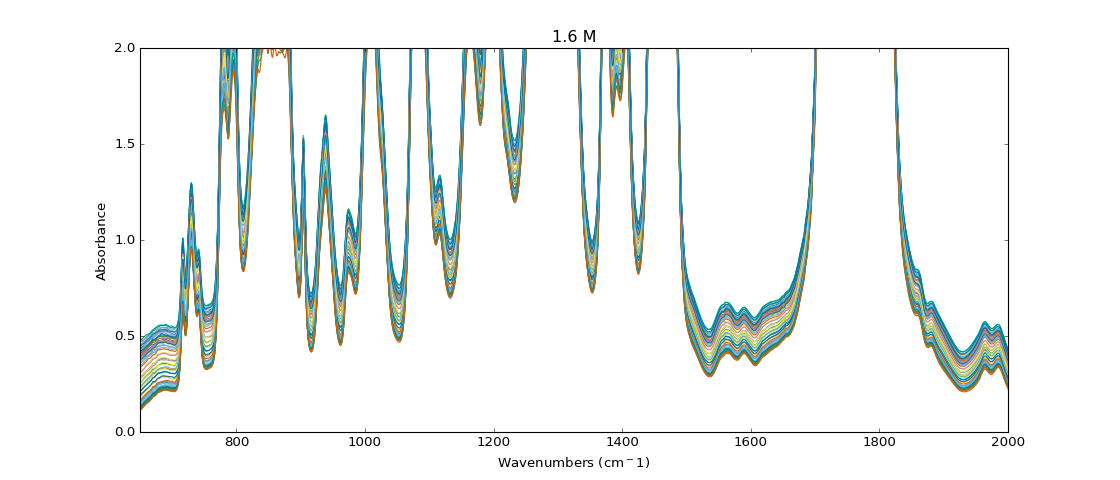

No such comm: 230a255a4c0e44a5a2416fa3431f106b
No such comm: 230a255a4c0e44a5a2416fa3431f106b
No such comm: 230a255a4c0e44a5a2416fa3431f106b
No such comm: 230a255a4c0e44a5a2416fa3431f106b
No such comm: beec232ebe334f35893467a9f7d3cd05
No such comm: beec232ebe334f35893467a9f7d3cd05
No such comm: beec232ebe334f35893467a9f7d3cd05
No such comm: beec232ebe334f35893467a9f7d3cd05
No such comm: beec232ebe334f35893467a9f7d3cd05
No such comm: a46e711bbbf542dfb4916dc15097c2ce
No such comm: a46e711bbbf542dfb4916dc15097c2ce
No such comm: a46e711bbbf542dfb4916dc15097c2ce
No such comm: a46e711bbbf542dfb4916dc15097c2ce
No such comm: a46e711bbbf542dfb4916dc15097c2ce
No such comm: 0277de3b85c04228b96411f02679c128
No such comm: 0277de3b85c04228b96411f02679c128
No such comm: 0277de3b85c04228b96411f02679c128
No such comm: 0277de3b85c04228b96411f02679c128
No such comm: 0277de3b85c04228b96411f02679c128
No such comm: 1adeef8f63114b2f86ef6fd196baabc2
No such comm: 1adeef8f63114b2f86ef6fd196baabc2
No such comm:

In [4]:
# create Molarity objects from the dictionary
keys = list(data_dict.keys())
Molarities = []
for i in range(len(data_dict)):
    # select an NDDataset object, create a Molarity object
    a = Molarity(obj = data_dict[keys[i]],M = keys[i],smooth = 2.0)

    # add to the list of Molarity arrays
    Molarities.append(a)

# try calling the values from the NNDataset

for i in Molarities:
    plt.figure(figsize = (14,6))
    i.plot_all(low = 650, high = 2000)
    plt.show()